# Yet another look at Telco customer churn problem

## TL;DR
### This notebook aims at showing the difference between Kaggle world and the real-world using telco churn dataset. An example, how you could look at the problem and build applicable solution, that might be acceptable by the business. 
### How to do some of the feature engineering and how to create training dataset that makes sense
### How to build a baseline model - I am not focusing on tuning the model or building multiple models, you all know how to do that better than me.
### I am trying to focus on consequences of the model and how important it is to put modelling into right business context and be able to show model value. 

- <a href='#1'>1. EDA</a>
    - <a href='#1.1'>1.1. Exploratory data analysis</a>
    - <a href='#1.2'>1.2. Missing Values exploration</a>
    - <a href='#1.3'>1.3. Churn breakdown</a>
    - <a href='#1.4'>1.4. Data distributions against Churn flag</a>
- <a href='#2'>2. Feature preparation</a>
    - <a href='#2.1'>2.1. Feature engineering</a>
- <a href='#3'>3. Modelling</a>
    - <a href='#3.1'>3.1. Analysing and transforming results</a>
    - <a href='#3.2'>3.2. Threshold selection</a>
- <a href='#4'>4. The consequences of our model</a>
    - <a href='#4.1'>4.1. Feature Importance</a>
    - <a href='#4.2'>4.2. Unconfusing confusion matrices</a>
    - <a href='#4.3'>4.3. Campaigning the model</a>
    - <a href='#4.4'>4.4. Customer Lifetime Value</a>
- <a href='#5'>5. Conclusions</a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import auc, f1_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import time
pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

### <a id='1'>1. EDA</a>

In [2]:
in_file = 'data\cell2celltrain.csv'

### <a id='1.1'>1.1. Exploratory data analysis</a>

In [3]:
df = pd.read_csv(in_file)

In [4]:
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [5]:
df.shape

(51047, 58)

### Class sizes

In [6]:
df.Churn.value_counts()

No     36336
Yes    14711
Name: Churn, dtype: int64

### Ratios
We take a note of class imbalance

In [7]:
df.Churn.value_counts()/df.shape[0]

No     0.711815
Yes    0.288185
Name: Churn, dtype: float64

### <a id='1.2'>1.2. Missing Values exploration</a>

### The usual suspects missing values check

In [8]:
# number of missing values in dataset
df.isnull().sum().values.sum()

3515

### Boom! We have missing vals but why? Let's roll up sleeves and check.
#### Despite number of techniques available, we will use common sense most of all, to determine whether or not missing value is there for a reason or missing at random

In [9]:
missing = list()
for x in df.columns:
    if df[x].isnull().sum() != 0:
        print(x, df[x].isnull().sum())
        missing.append(x)

MonthlyRevenue 156
MonthlyMinutes 156
TotalRecurringCharge 156
DirectorAssistedCalls 156
OverageMinutes 156
RoamingCalls 156
PercChangeMinutes 367
PercChangeRevenues 367
ServiceArea 24
Handsets 1
HandsetModels 1
CurrentEquipmentDays 1
AgeHH1 909
AgeHH2 909


#### From above list we can remove straight away: MonthlyRevenue, MonthlyMinutes, TotalRecurringCharge, RoamingCalls, PercChangeMinutes, PercChangeRevenues, Handsets, HandsetModels, CurrentEquipmentDays, OverageMinutes.
#### As, above features simply could have zero value or be not present at all. We'll set them to zero 'safely'. We'll investigate the remaining lot!

In [10]:
# First of, what on earthe is this feature name? is the Director assisting calls?
df.DirectorAssistedCalls.describe()

count    50891.000000
mean         0.895229
std          2.228546
min          0.000000
25%          0.000000
50%          0.250000
75%          0.990000
max        159.390000
Name: DirectorAssistedCalls, dtype: float64

#### Stats are showing that the most values are zero, so this could be calls to call centre, where customer said 
### 'I want to speak to your MANAGER!'

(-8.26288580685301, 25)

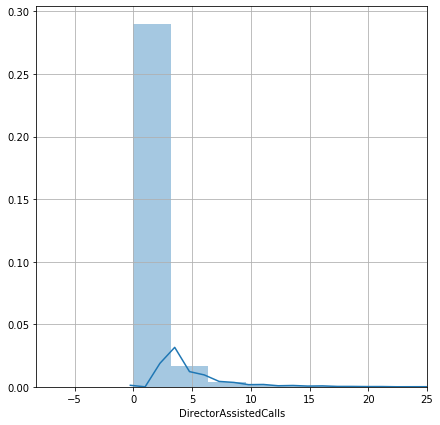

In [11]:
plt.figure(figsize=(7,7))
plt.grid(True)
sns.distplot(df.DirectorAssistedCalls.fillna(0))
plt.xlim(right=25)

does it have an impact on churn?

In [12]:
df.Churn[df.DirectorAssistedCalls != 0].value_counts()

No     19120
Yes     7415
Name: Churn, dtype: int64

... hmmmm interesting, recall from above that our churn population in data set is 14711, and with this feature we're capturing a lot of churners. However, way more non-churnes to be fair.

In [13]:
# ratios against all customer population
df.Churn[df.DirectorAssistedCalls != 0].value_counts()/df.shape[0]

No     0.374557
Yes    0.145258
Name: Churn, dtype: float64

### I think we can zero-out this feature

### We've left with missing vals in Age let's look at stats first

In [14]:
df.AgeHH1.describe()

count    50138.000000
mean        31.338127
std         22.094635
min          0.000000
25%          0.000000
50%         36.000000
75%         48.000000
max         99.000000
Name: AgeHH1, dtype: float64

In [15]:
df.AgeHH2.describe()

count    50138.000000
mean        21.144142
std         23.931368
min          0.000000
25%          0.000000
50%          0.000000
75%         42.000000
max         99.000000
Name: AgeHH2, dtype: float64

### How many records are impacted by 0 age
This could be due to many reasons:
> customers given option not to report age

> 'Clerical' error

> recent change in system

> ETL process crashed


In [16]:
df.Churn[(df.AgeHH1.fillna(0) == 0)&(df.AgeHH2.fillna(0) == 0)].value_counts()

No     10371
Yes     4455
Name: Churn, dtype: int64

### Some missing values conclusions.
In my opinion is safe to 0 substitute all missing variables in this data set.
As we showing above, there could be some data missing at random, however vast majority is due to the processes like data gathering, data entering, choice for customer that results in missing information.

In [17]:
df = df.fillna(0)

### <a id='1.3'>1.3. Churn breakdown</a>

## Let's take a look at churn and how it's reflected in some of the features

In [18]:
#get a list of categoricals
categoricals = list()
for x in df.columns:
    if df[x].dtype == 'object':
        categoricals.append(x)

In [19]:
df[categoricals].nunique()

Churn                        2
ServiceArea                748
ChildrenInHH                 2
HandsetRefurbished           2
HandsetWebCapable            2
TruckOwner                   2
RVOwner                      2
Homeownership                2
BuysViaMailOrder             2
RespondsToMailOffers         2
OptOutMailings               2
NonUSTravel                  2
OwnsComputer                 2
HasCreditCard                2
NewCellphoneUser             2
NotNewCellphoneUser          2
OwnsMotorcycle               2
HandsetPrice                16
MadeCallToRetentionTeam      2
CreditRating                 7
PrizmCode                    4
Occupation                   8
MaritalStatus                3
dtype: int64

### Most of categoricals are binary so let's see how the churn is reflected in some other variables

In [20]:
def plot_val_counts(df, col=''):
    plt.figure(figsize=(5,5))
    plt.grid(True)
    plt.bar(df[col][df.Churn=='Yes'].value_counts().index, 
            df[col][df.Churn=='Yes'].value_counts().values)
    plt.title(f'{col}')
    plt.xticks(rotation=-90)

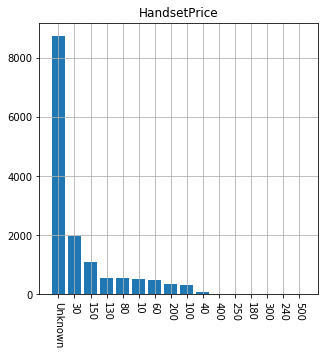

In [21]:
plot_val_counts(df, col='HandsetPrice')

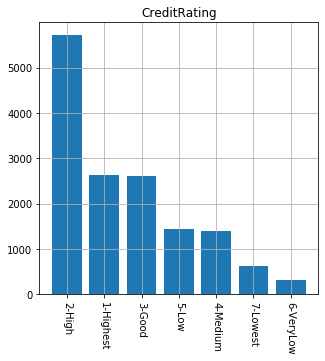

In [22]:
plot_val_counts(df, col='CreditRating')

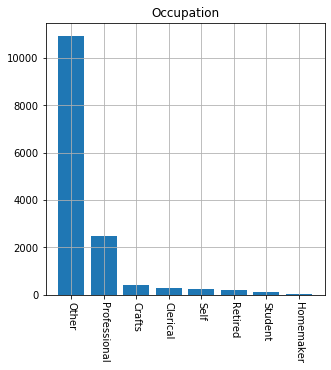

In [23]:
plot_val_counts(df, col='Occupation')

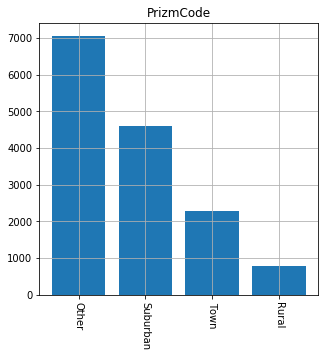

In [24]:
plot_val_counts(df, col='PrizmCode')

### <a id='1.4'>1.4. Data distributions</a>
### Data distributions

In [25]:
def plot_distro(df, col = '', y_limit=None, x_limit_r=None, x_limit_l = None):
    plt.figure(figsize=(10,10))
    plt.grid(True)
    sns.distplot(df[col][df.Churn == 'Yes'])
    sns.distplot(df[col][df.Churn == 'No'])
    plt.legend(['churn_flag_yes', 'churn_flag_no'])
    if y_limit:
        plt.ylim(top=y_limit)
    if x_limit_r:
        plt.xlim(right=x_limit_r)
    if x_limit_l:
        plt.xlim(left=x_limit_l)

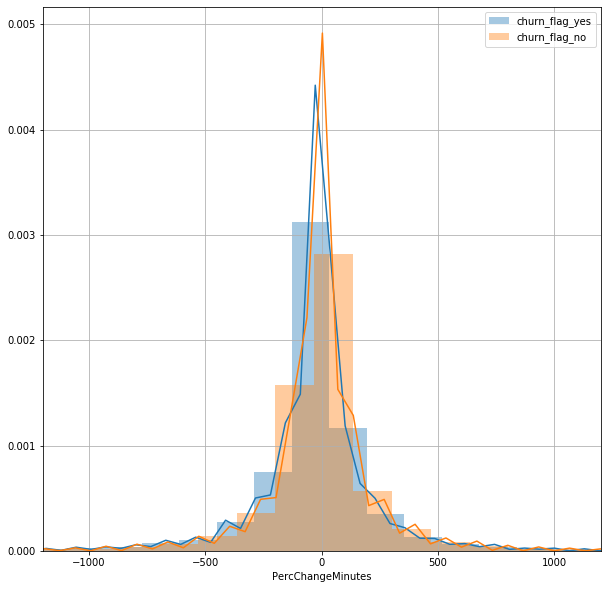

In [26]:
plot_distro(df, col='PercChangeMinutes', x_limit_r=1200, x_limit_l=-1200)

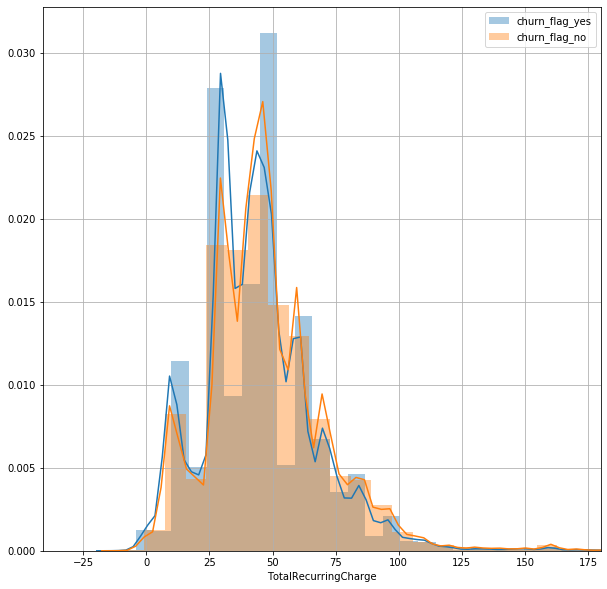

In [27]:
plot_distro(df, col='TotalRecurringCharge', x_limit_r=180)

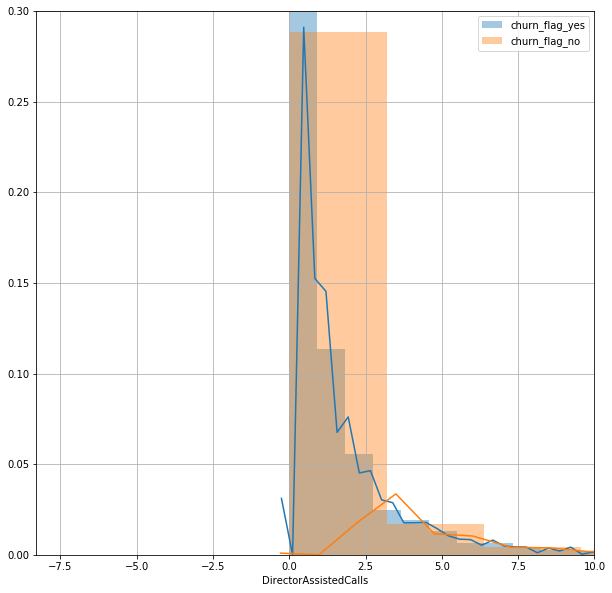

In [28]:
plot_distro(df, col='DirectorAssistedCalls', y_limit=.3, x_limit_r=10)

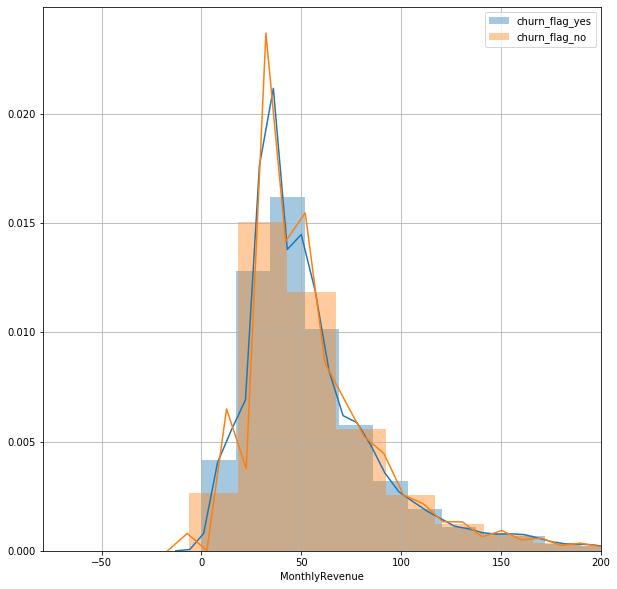

In [29]:
plot_distro(df, col='MonthlyRevenue', x_limit_r=200)

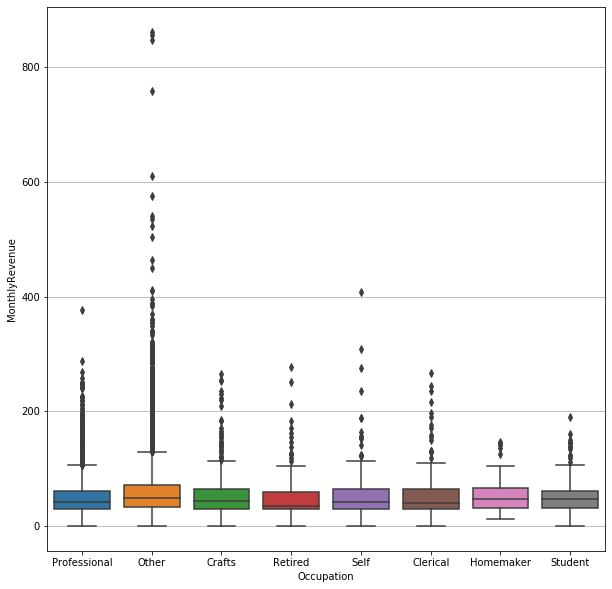

In [30]:
plt.figure(figsize=(10,10))
plt.grid(True)
sns.boxplot(x=df.Occupation[df.Churn == 'Yes'], y=df.MonthlyRevenue[df.Churn == 'Yes'])
#sns.boxplot(x=df.Occupation[df.Churn == 'No'], y=df.MonthlyRevenue[df.Churn == 'No'])

### Not much of a difference visible from this perspective, let's zoom in

(-67.64750000000001, 100)

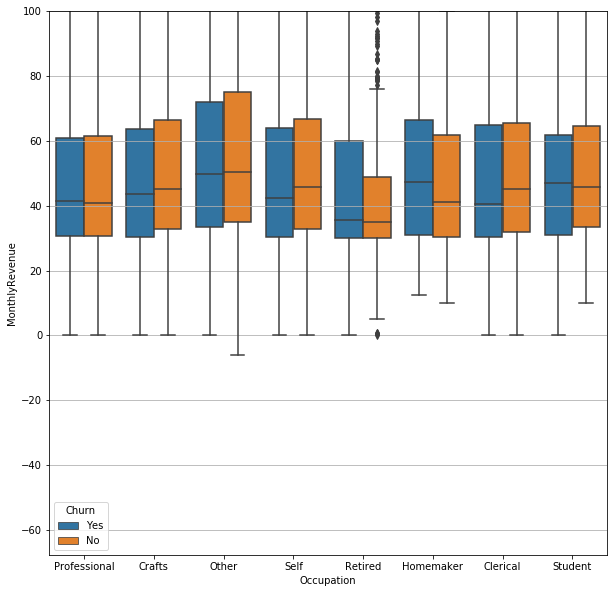

In [31]:
plt.figure(figsize=(10,10))
plt.grid(True)
sns.boxplot(x=df.Occupation, y=df.MonthlyRevenue, hue=df.Churn)
plt.ylim(top=100)

(-67.64750000000001, 150)

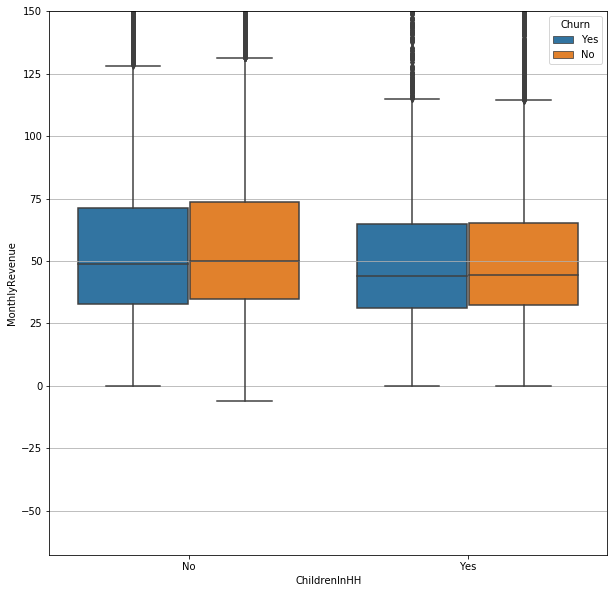

In [32]:
plt.figure(figsize=(10,10))
plt.grid(True)
sns.boxplot(x=df.ChildrenInHH, y=df.MonthlyRevenue, hue=df.Churn)
#sns.boxplot(x=df.ChildrenInHH[df.Churn == 'No'], y=df.MonthlyRevenue[df.Churn == 'No'])
plt.ylim(top=150)

### Let's note that differences are just subtle, there are no obvious relationships between Occupation and churn

### Customer tenure and churn

In [33]:
df.MonthsInService.describe()

count    51047.000000
mean        18.756264
std          9.800138
min          6.000000
25%         11.000000
50%         16.000000
75%         24.000000
max         61.000000
Name: MonthsInService, dtype: float64

In [34]:
tenure_churn = df.MonthsInService[df.Churn == 'Yes'].value_counts()
tenure_no_churn = df.MonthsInService[df.Churn == 'No'].value_counts()

In [35]:
tenure = pd.merge(tenure_churn.reset_index(), tenure_no_churn.reset_index(), on='index')

In [36]:
tenure = tenure.sort_values(by='index')

In [37]:
tenure = tenure.reset_index().drop(columns='level_0')

In [38]:
tenure.columns

Index(['index', 'MonthsInService_x', 'MonthsInService_y'], dtype='object')

Text(0.5, 1.0, 'When the churn picks')

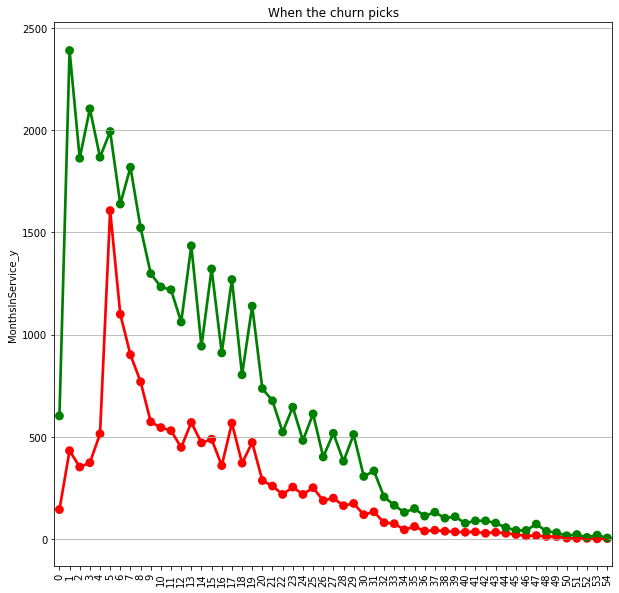

In [39]:
plt.figure(figsize=(10,10))
plt.grid(True)
sns.pointplot(x=tenure.index, y=tenure.MonthsInService_x, color='red')
sns.pointplot(x=tenure.index, y=tenure.MonthsInService_y, color='green')
plt.xticks(rotation=90)
plt.title('When the churn picks')

### <a id='2.1'>2.1. Feature preparation</a>

### Let's look at type of features and how we could categorize them

In [40]:
def get_lists_of_dtypes(df):
    """
    Helper function to create list of features by type and by number of unique
    values they consist of.
    """
    strings = list()
    integers = list()
    floats = list()
    # Checking for partial string match to append accordingly value type
    # As here we might have different type of ints and floats
    # Note that strings we're returning as dictionary, to have number of unique vals for each feature
    for x in df.columns[2:]:
        if str(df[x].dtype)[:3] in 'obj':
            strings.append({x:len(df[x].unique())})
        elif str(df[x].dtype)[:3] in 'int':
            integers.append(x)
        elif str(df[x].dtype)[:3] in 'flo':
            floats.append(x)
        else:
            continue
    return strings,integers, floats

In [41]:
s, i, f = get_lists_of_dtypes(df)

## Let's investigate strings and number of unique values
### Below we can see that features with 2 unique values are already encoded
### as binary type [0,1] - so we can leave them as they are
### remaining features we will one hot encode including ServiceArea despite having 748 unique values
### as this feature might have an impact on model, due to larger population density
### therefore, might have higher/lower churn propensity

In [42]:
s

[{'ServiceArea': 748},
 {'ChildrenInHH': 2},
 {'HandsetRefurbished': 2},
 {'HandsetWebCapable': 2},
 {'TruckOwner': 2},
 {'RVOwner': 2},
 {'Homeownership': 2},
 {'BuysViaMailOrder': 2},
 {'RespondsToMailOffers': 2},
 {'OptOutMailings': 2},
 {'NonUSTravel': 2},
 {'OwnsComputer': 2},
 {'HasCreditCard': 2},
 {'NewCellphoneUser': 2},
 {'NotNewCellphoneUser': 2},
 {'OwnsMotorcycle': 2},
 {'HandsetPrice': 16},
 {'MadeCallToRetentionTeam': 2},
 {'CreditRating': 7},
 {'PrizmCode': 4},
 {'Occupation': 8},
 {'MaritalStatus': 3}]

### <a id='2.1'>2.1. Feature engineering</a>

In [43]:
def prep_categorical_features(s):
    """
    helper function to return features that we want to one hot encode
    """
    one_hot = list()
    binary = list()
    for x in s:
        for k, v in x.items():
            if v > 2:
                one_hot.append(k)
            else:
                binary.append(k)
    return one_hot, binary

In [44]:
one_hot, binary = prep_categorical_features(s)

### Prep numerical pairwise features
### as in many feature engineering techniques we will use some of the well known tricks
> pairwise sum, diff, ratio

> min, max, mean

### Let's write a function to do just that

In [45]:
def pairwise(col_1, col_2):
    """
    calculates pairwise features
    for given two dataframe columns
    """
    tot = col_1 + col_2
    diff = col_1 - col_2
    ratio = col_1/col_2
    return tot, diff, ratio

In [46]:
def stats(col):
    """
    calculates stats for given
    dataframe column
    """
    mini = col.min()
    maxi = col.max()
    avg = col.mean()
    return mini, maxi, avg

In [47]:
def feature_engine_numericals(dff, i, f):
    """
    Expands dataframe based on current lists of
    numerical features (int, floats)
    """
    numericals = i + f
    df = dff.copy()
    for x in numericals:
        df[f'{x}_min'], df[f'{x}_max'], df[f'{x}_mean'] = stats(df[x])
        for e in numericals:
            if e==x:
                pass
            else:
                df[f'sum_{x}_{e}'], df[f'diff_{x}_{e}'], df[f'ratio_{x}_{e}'] = pairwise(df[x], df[e])
    return df

In [48]:
%%time
pair_df = feature_engine_numericals(df, i, f)

Wall time: 27.2 s


### Feature engineering on categoricals transformations

In [49]:
def feature_engine_categoricals(dff, binary, one_hot):
    """
    Function to expand dataframe by one-hot encoding
    categorical variables also, changes datatype to float
    """
    df = dff.copy()
    lb = LabelBinarizer()
    for b in binary:
        df[f'{b}_tr'] = lb.fit_transform(df[b]).astype(np.float64)
        df = df.drop(columns=b)
    df = pd.get_dummies(df, columns=one_hot, dtype=float)
    return df

In [50]:
%%time
pair_df = feature_engine_categoricals(pair_df, binary, one_hot)

Wall time: 38.9 s


In [51]:
pair_df.shape, df.shape

((51047, 4306), (51047, 58))

In [52]:
pair_df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,MonthsInService_min,MonthsInService_max,MonthsInService_mean,sum_MonthsInService_UniqueSubs,diff_MonthsInService_UniqueSubs,ratio_MonthsInService_UniqueSubs,sum_MonthsInService_ActiveSubs,diff_MonthsInService_ActiveSubs,ratio_MonthsInService_ActiveSubs,sum_MonthsInService_RetentionCalls,diff_MonthsInService_RetentionCalls,ratio_MonthsInService_RetentionCalls,sum_MonthsInService_RetentionOffersAccepted,diff_MonthsInService_RetentionOffersAccepted,ratio_MonthsInService_RetentionOffersAccepted,sum_MonthsInService_ReferralsMadeBySubscriber,diff_MonthsInService_ReferralsMadeBySubscriber,ratio_MonthsInService_ReferralsMadeBySubscriber,sum_MonthsInService_IncomeGroup,diff_MonthsInService_IncomeGroup,ratio_MonthsInService_IncomeGroup,sum_MonthsInService_AdjustmentsToCreditRating,diff_MonthsInService_AdjustmentsToCreditRating,ratio_MonthsInService_AdjustmentsToCreditRating,sum_MonthsInService_MonthlyRevenue,diff_MonthsInService_MonthlyRevenue,ratio_MonthsInService_MonthlyRevenue,sum_MonthsInService_MonthlyMinutes,diff_MonthsInService_MonthlyMinutes,ratio_MonthsInService_MonthlyMinutes,sum_MonthsInService_TotalRecurringCharge,diff_MonthsInService_TotalRecurringCharge,ratio_MonthsInService_TotalRecurringCharge,sum_MonthsInService_DirectorAssistedCalls,diff_MonthsInService_DirectorAssistedCalls,ratio_MonthsInService_DirectorAssistedCalls,sum_MonthsInService_OverageMinutes,diff_MonthsInService_OverageMinutes,ratio_MonthsInService_OverageMinutes,sum_MonthsInService_RoamingCalls,diff_MonthsInService_RoamingCalls,ratio_MonthsInService_RoamingCalls,sum_MonthsInService_PercChangeMinutes,diff_MonthsInService_PercChangeMinutes,ratio_MonthsInService_PercChangeMinutes,sum_MonthsInService_PercChangeRevenues,diff_MonthsInService_PercChangeRevenues,ratio_MonthsInService_PercChangeRevenues,sum_MonthsInService_DroppedCalls,diff_MonthsInService_DroppedCalls,ratio_MonthsInService_DroppedCalls,sum_MonthsInService_BlockedCalls,diff_MonthsInService_BlockedCalls,ratio_MonthsInService_BlockedCalls,sum_MonthsInService_UnansweredCalls,diff_MonthsInService_UnansweredCalls,ratio_MonthsInService_UnansweredCalls,sum_MonthsInService_CustomerCareCalls,diff_MonthsInService_CustomerCareCalls,ratio_MonthsInService_CustomerCareCalls,sum_MonthsInService_ThreewayCalls,diff_MonthsInService_ThreewayCalls,ratio_MonthsInService_ThreewayCalls,sum_MonthsInService_ReceivedCalls,...,ServiceArea_SFROAK510,ServiceArea_SFROAK925,ServiceArea_SFRPAL650,ServiceArea_SFRRCM510,ServiceArea_SFRROC916,ServiceArea_SFRSAC916,ServiceArea_SFRSCL408,ServiceArea_SFRSFR415,ServiceArea_SFRSFS650,ServiceArea_SFRSGS530,ServiceArea_SFRSMO650,ServiceArea_SFRSRO707,ServiceArea_SFRVAC707,ServiceArea_SFRWLC925,ServiceArea_SFRWOO530,ServiceArea_SFRWTV831,ServiceArea_SFURED530,ServiceArea_SFUSAC530,ServiceArea_SHECAR717,ServiceArea_SHECHA717,ServiceArea_SHEEDI540,ServiceArea_SHEFTR540,ServiceArea_SHEHAG301,ServiceArea_SHEHAR540,ServiceArea_SHEMAR304,ServiceArea_SHEMYE301,ServiceArea_SHEWIN540,ServiceArea_SHEYOR717,ServiceArea_SLCKAY801,ServiceArea_SLCOGD801,ServiceArea_SLCPRK435,ServiceArea_SLCPRO801,ServiceArea_SLCSLC801,ServiceArea_SLCTOO801,ServiceArea_SLUSTG435,ServiceArea_STLCHA636,ServiceArea_STLCHE636,ServiceArea_STLCMB573,ServiceArea_STLCOL618,ServiceArea_STLCPG573,ServiceArea_STLCRD618,ServiceArea_STLFUL573,ServiceArea_STLHNB573,ServiceArea_STLJEF573,ServiceArea_STLJOP417,ServiceArea_STLJOS816,ServiceArea_STLOZA573,ServiceArea_STLPIT316,ServiceArea_ST

### <a id='3'>3. Modelling</a>

### Encode labels and separate features and labels

In [53]:
le = LabelEncoder()

In [54]:
lab = le.fit_transform(pair_df.Churn).astype(np.float64)

In [55]:
l = pd.DataFrame({'lbls':pair_df.Churn, 'l_tr':lab})

In [56]:
l.head()

,lbls,l_tr
0,Yes,1.0
1,Yes,1.0
2,No,0.0
3,No,0.0
4,Yes,1.0


> 1 - customers who have churned

> 0 - customers retained

In [57]:
feats = pair_df.iloc[:,2:]

### Split for train test

In [58]:
x_train, x_test, y_train, y_test = train_test_split(feats, lab, test_size = .25, random_state = 7)

### Split train for train and eval

In [59]:
x_tr, x_ev, y_tr, y_ev = train_test_split(x_train, y_train, test_size = .05, random_state = 7)

In [60]:
x_tr.shape, x_ev.shape, y_tr.dtype, y_ev.dtype

((36370, 4304), (1915, 4304), dtype('float64'), dtype('float64'))

In [61]:
train_data = lgbm.Dataset(data=x_tr, label=y_tr)
val_data = lgbm.Dataset(data=x_ev, label=y_ev)

### Model params

In [62]:
# tuning copied from https://www.kaggle.com/avanwyk/a-lightgbm-overview
# Note that there is no param search here, as this is meant to be a base line model.

advanced_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    
    'learning_rate': 0.1,
    'num_leaves': 141, # more leaves increases accuracy, but may lead to overfitting.
    
    'max_depth': 7, # the maximum tree depth. Shallower trees reduce overfitting.
    'min_split_gain': 0, # minimal loss gain to perform a split
    'min_child_samples': 21, # or min_data_in_leaf: specifies the minimum samples per leaf node.
    'min_child_weight': 5, # minimal sum hessian in one leaf. Controls overfitting.
    
    'lambda_l1': 0.5, # L1 regularization
    'lambda_l2': 0.5, # L2 regularization
    
    'feature_fraction': 0.7, # randomly select a fraction of the features before building each tree.
    # Speeds up training and controls overfitting.
    'bagging_fraction': 0.5, # allows for bagging or subsampling of data to speed up training.
    'bagging_freq': 0, # perform bagging on every Kth iteration, disabled if 0.
    
    'scale_pos_weight': 99, # add a weight to the positive class examples (compensates for imbalance).
    
    'subsample_for_bin': 200000, # amount of data to sample to determine histogram bins
    'max_bin': 1000, # the maximum number of bins to bucket feature values in.
    # LightGBM autocompresses memory based on this value. Larger bins improves accuracy.
    
    'nthread': 4, # number of threads to use for LightGBM, best set to number of actual cores.
}

### Model train

In [63]:
# train function from https://www.kaggle.com/avanwyk/a-lightgbm-overview
def train_gbm(params, training_set, validation_set, init_gbm=None, boost_rounds=100, early_stopping_rounds=0, metric='auc'):
    evals_result = {} 

    gbm = lgbm.train(params, # parameter dict to use
                    training_set,
                    init_model=init_gbm, # initial model to use, for continuous training.
                    num_boost_round=boost_rounds, # the boosting rounds or number of iterations.
                    early_stopping_rounds=early_stopping_rounds, # early stopping iterations.
                    # stop training if *no* metric improves on *any* validation data.
                    valid_sets=validation_set,
                    evals_result=evals_result, # dict to store evaluation results in.
                    verbose_eval=True) # print evaluations during training.
    
    return gbm, evals_result

In [64]:
gbm, evals_result = train_gbm(advanced_params, training_set=train_data, validation_set=val_data,
                             boost_rounds=1000, early_stopping_rounds=50)

[1]	valid_0's auc: 0.61376
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.632222
[3]	valid_0's auc: 0.646331
[4]	valid_0's auc: 0.653136
[5]	valid_0's auc: 0.648324
[6]	valid_0's auc: 0.646411
[7]	valid_0's auc: 0.648468
[8]	valid_0's auc: 0.647772
[9]	valid_0's auc: 0.647437
[10]	valid_0's auc: 0.646168
[11]	valid_0's auc: 0.648646
[12]	valid_0's auc: 0.646539
[13]	valid_0's auc: 0.645688
[14]	valid_0's auc: 0.64783
[15]	valid_0's auc: 0.646709
[16]	valid_0's auc: 0.646357
[17]	valid_0's auc: 0.649667
[18]	valid_0's auc: 0.649164
[19]	valid_0's auc: 0.651016
[20]	valid_0's auc: 0.650758
[21]	valid_0's auc: 0.650726
[22]	valid_0's auc: 0.652341
[23]	valid_0's auc: 0.651558
[24]	valid_0's auc: 0.651431
[25]	valid_0's auc: 0.651741
[26]	valid_0's auc: 0.652336
[27]	valid_0's auc: 0.653764
[28]	valid_0's auc: 0.653603
[29]	valid_0's auc: 0.653107
[30]	valid_0's auc: 0.653044
[31]	valid_0's auc: 0.654391
[32]	valid_0's auc: 0.655869
[33]	valid_0's auc: 0

In [65]:
y_hat = gbm.predict(x_test)

### <a id='3.1'>3.1. Analysing and transforming results</a>

In [66]:
test_res = pd.DataFrame({'y_true':y_test, 'y_hat':y_hat})

In [67]:
test_res.y_hat[test_res.y_true == 0].shape, test_res.y_hat[test_res.y_true == 1].shape

((9100,), (3662,))

In [68]:
roc_auc_score(test_res.y_true, test_res.y_hat)

0.6578284850048913

In [69]:
test_res.y_hat[test_res.y_true == 0].describe()

count    9100.000000
mean        0.913424
std         0.142168
min         0.005509
25%         0.927423
50%         0.964532
75%         0.975888
max         0.993614
Name: y_hat, dtype: float64

In [70]:
test_res.y_hat[test_res.y_true == 1].describe()

count    3662.000000
mean        0.951760
std         0.088543
min         0.011071
25%         0.960658
50%         0.974685
75%         0.980713
max         0.994273
Name: y_hat, dtype: float64

In [71]:
def plot_distro(df, col = '', fiter_col = '', y_limit=None, x_limit_r=None, x_limit_l = None):
    plt.figure(figsize=(10,10))
    plt.grid(True)
    sns.distplot(df[col][df[fiter_col] == 1])
    sns.distplot(df[col][df[fiter_col] == 0])
    plt.legend(['churn_flag_yes', 'churn_flag_no'])
    if y_limit:
        plt.ylim(top=y_limit)
    if x_limit_r:
        plt.xlim(right=x_limit_r)
    if x_limit_l:
        plt.xlim(left=x_limit_l)

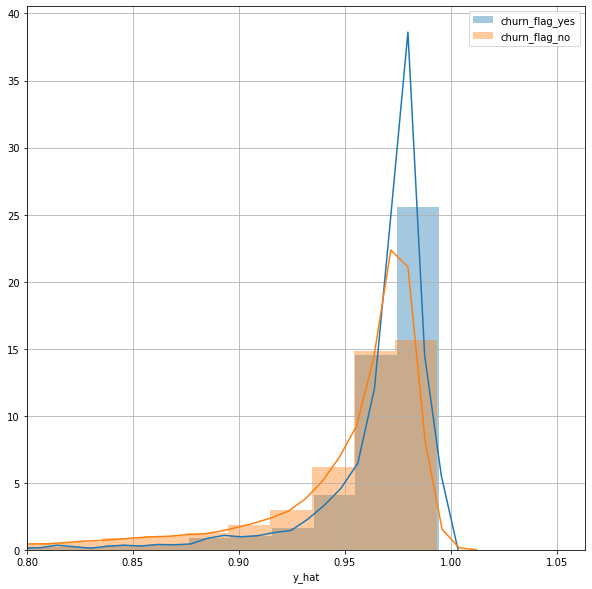

In [72]:
plot_distro(test_res, col = 'y_hat', fiter_col = 'y_true', y_limit=None, x_limit_r=None, x_limit_l = .8)

### Let's transform the results to separate two distributions as far as possible

### <a id='3.2'>3.2. Threshold selection</a>

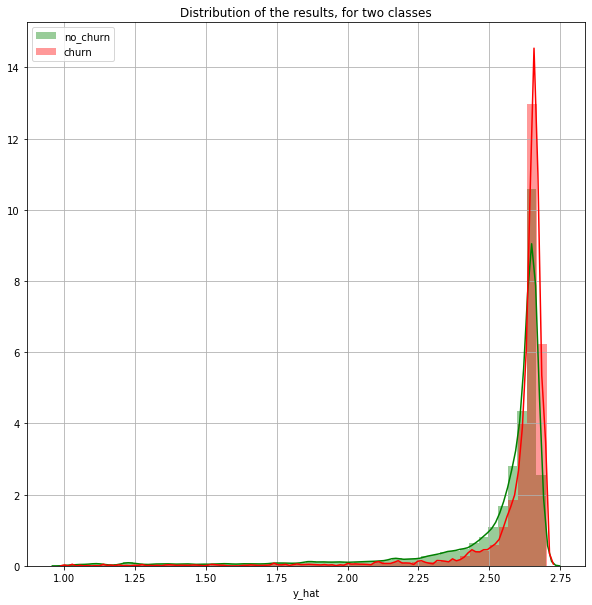

In [73]:
plt.figure(figsize=(10,10))
plt.grid(True)
sns.distplot(np.exp(test_res.y_hat[test_res.y_true == 0]), color='green')
sns.distplot(np.exp(test_res.y_hat[test_res.y_true == 1]), color='red')
plt.title('Distribution of the results, for two classes')
plt.legend(['no_churn', 'churn'])

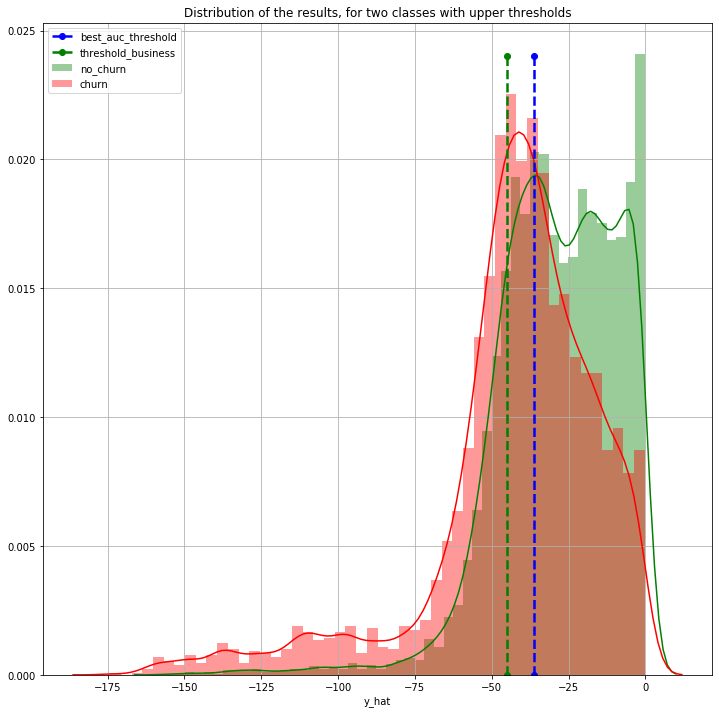

In [74]:
plt.figure(figsize=(12,12))
plt.grid(True)
sns.distplot(1/np.log(test_res.y_hat[test_res.y_true == 0]), color='green')
sns.distplot(1/np.log(test_res.y_hat[test_res.y_true == 1]), color='red')
plt.plot([-36.3, -36.3], [0, 0.024], 'bo--', linewidth=2.5)
plt.plot([-45, -45], [0, 0.024], 'go--', linewidth=2.5)
plt.title('Distribution of the results, for two classes with upper thresholds')

plt.legend(['best_auc_threshold','threshold_business', 'no_churn', 'churn'])

### Now we can investigate how to select the threshold for setting churn flag = 1
### Above plot implies that there's no perfect separation, as this is always the case in real life
### Therefore, we have to look for so called 'swee tspot' where we maximise impact of the model
### In the industry treshold is usually determined by business who uses model
### In Kaggle we're looking for best AUC threshold, if that's the metric on leader board
### I will focus on business case here. You all know how to do it the other way ;)
#### from below descriptive stats we could start at -39

In [75]:
1/np.log(test_res['y_hat'][test_res['y_true'] == 1]).describe()

count      0.000273
mean     -16.926877
std        5.490489
min       -0.222053
25%      -24.914509
50%      -38.999845
75%      -51.347636
max     -174.116712
Name: y_hat, dtype: float64

### Transform results accordingly

In [76]:
test_res['y_transformed'] = 1/np.log(test_res['y_hat'])

In [77]:
def plot_roc_curve(test_res, threshold = -39):
    ns_probs = [0 for _ in range(len(test_res))]
    fpr, tpr, threshold = roc_curve(test_res.y_true, np.where(test_res.y_transformed < threshold, 1, 0))
    _fpr_, _tpr_, _threshold_ = roc_curve(test_res.y_true, ns_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.grid(True)
    plt.title("ROC Curve. Area under Curve: {:.3f}".format(roc_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    _ = plt.plot(fpr, tpr, 'r')
    __ = plt.plot(_fpr_, _tpr_, 'b', ls = '--' )

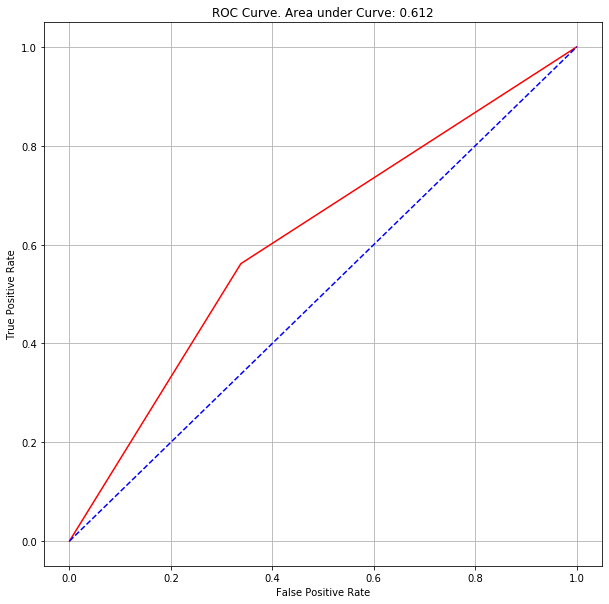

In [78]:
plot_roc_curve(test_res, -36.3)

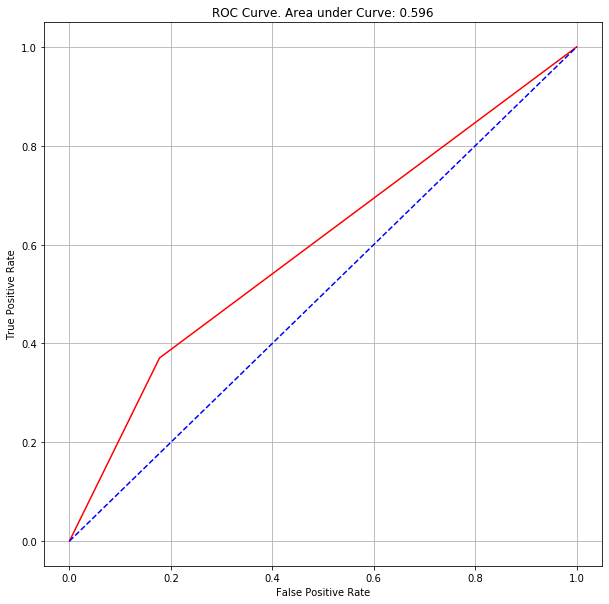

In [79]:
plot_roc_curve(test_res, -45)

### <a id='4'>4. The consequences of our model</a>

### Each model deployed in production or considered for deployment has its consequences. Rarely spoken in ML literature in these terms. As we, Data Scientists, tend to talk in True Positive, True Negatives, False Positives, False Negatives terms. We need to bring these terms to business in their jargon, especially to be able to explain the impact and put Dollar figure on top of the results. In my experience the simpler these terms are the more successful you will be with productionizing the model, that's what we aim for, right?
### So, here we will focus a bit on how business see this problem and what we Data Scientist might do to maximise chance of success

In [80]:
test_res.y_transformed

0       -17.548846
1        -6.225876
2       -15.476352
3       -35.154334
4       -37.370708
           ...    
12757   -31.141347
12758    -6.917583
12759   -38.530766
12760    -1.775361
12761   -27.085954
Name: y_transformed, Length: 12762, dtype: float64

### Here we'll look at confusion matrices, where we can see how change in the threshold impacts the results. Having the results in this form we have one foot in the door. But still we need more explanation.

### So, here is a little bit of industry context. Most of the companies these days have models that have customer retention as a main goal. These models are run by Marketing teams or CVM teams (Customer Value Management) or perhaps some other function. As Data Scientist you need to gain their trust. They won't buy in to Blackbox solution right away i.e. Deep Learning model, they will have to understand what's going on, under the hood. This we can achieve in multiple ways, some examples:
> Feature importance that make sense to the business, tree-based models are good for that, but sometimes results are funny

> Confusion matrix explanation and business impact of the model

### <a id='4.1'>4.1 Feature Importance</a> 

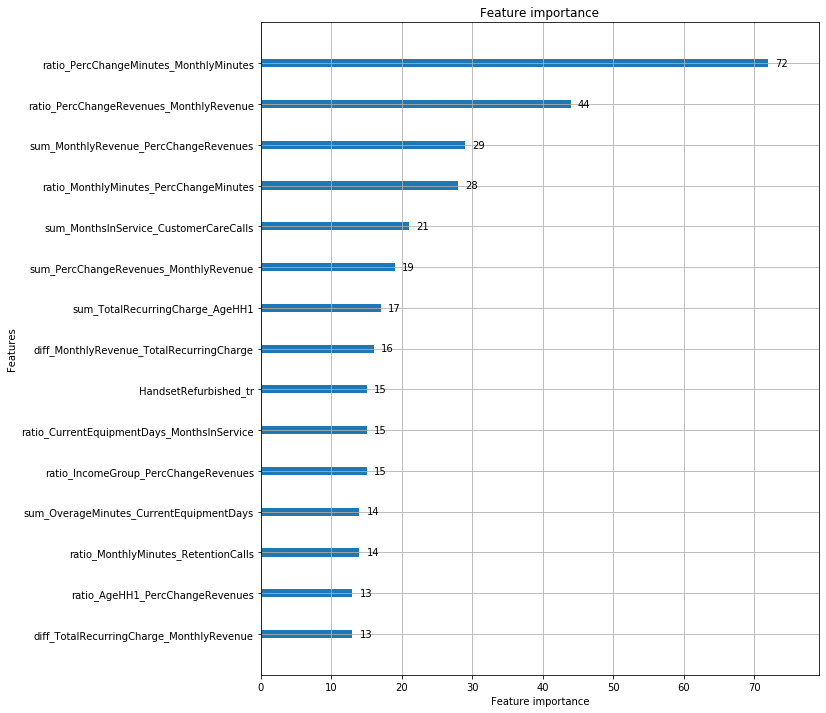

In [81]:
lgbm.plot_importance(gbm, figsize=(10,12), max_num_features=15,importance_type='split' )

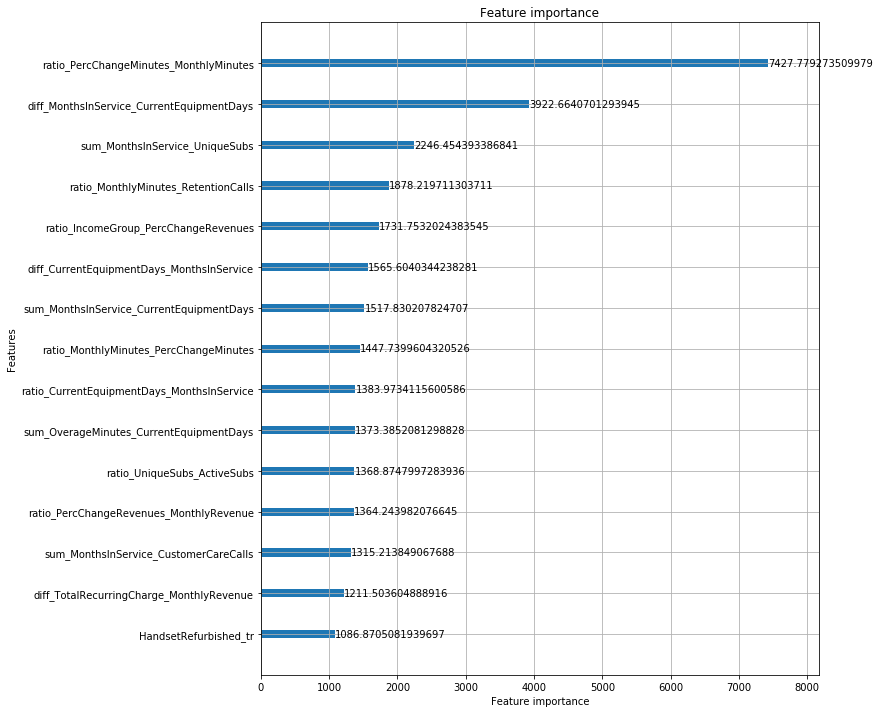

In [82]:
lgbm.plot_importance(gbm, figsize=(10,12), max_num_features=15,importance_type='gain' )

### From above feature importance plots, we see that almost all most important features are engineered.

### <a id='4.2'>4.2 Unconfusing confusion matrices</a>

In [83]:
def plot_conf_mat(cm):
    """
    Helper function to plot confusion matrix.
    With text centerred.
    """
    plt.figure(figsize=(8,8))
    ax = sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

### Here we visualise matrices. 
> First from auc view point

> Second what I call business view point

In [84]:
# AUC
cm_auc = confusion_matrix(test_res.y_true, np.where(test_res.y_transformed < -36.3, 1, 0), labels=[0, 1])

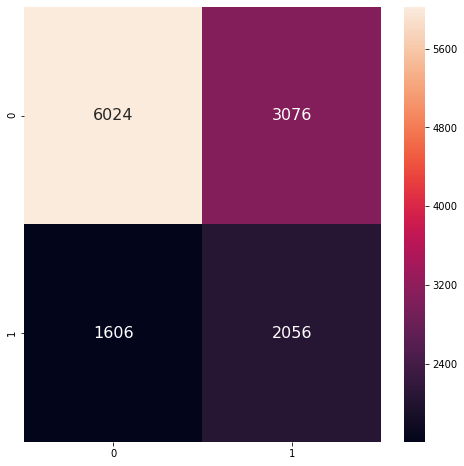

In [85]:
plot_conf_mat(cm_auc)

In [86]:
# Business
cm_bus = confusion_matrix(test_res.y_true, np.where(test_res.y_transformed < -43, 1, 0), labels=[0, 1])

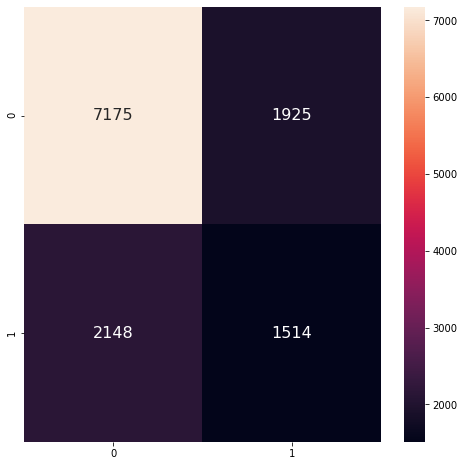

In [87]:
plot_conf_mat(cm_bus)

In [88]:
# Our testing population
test_res.y_true.value_counts()

0.0    9100
1.0    3662
Name: y_true, dtype: int64

### <a id='4.3'>4.3 Campaigning the model</a>

### So now, let's see how the model would be campaigned, and what would be an impact of the model

In [89]:
test_res.head()

,y_true,y_hat,y_transformed
0,0.0,0.944609,-17.548846
1,0.0,0.851616,-6.225876
2,0.0,0.937429,-15.476352
3,0.0,0.971955,-35.154334
4,0.0,0.973596,-37.370708


In [90]:
# first threshold to explore is AUC oriented -36.3
auc_based = test_res[test_res.y_transformed <= -36.3]
auc_based.y_true.value_counts()

0.0    3076
1.0    2056
Name: y_true, dtype: int64

In [91]:
auc_based.y_true.value_counts()/auc_based.shape[0]

0.0    0.599376
1.0    0.400624
Name: y_true, dtype: float64

### So, our model would target over 5k customers in a campaign 60% of which wouldn't churn, 40% with higher churn propensity. Here the model would offer incentives to 3k customers that don't need them and 2k that might need them. The question here is, how many of 2k customers we would retain and how many would churn anyway?

### Unfortunately, there's no ideal solution we'd have to run campaign and study the results with A/B tests

In [92]:
# second threshold to explore would be Business oriented -43
bus_based = test_res[test_res.y_transformed <= -43]
bus_based.y_true.value_counts()

0.0    1925
1.0    1514
Name: y_true, dtype: int64

In [93]:
bus_based.y_true.value_counts()/bus_based.shape[0]

0.0    0.559756
1.0    0.440244
Name: y_true, dtype: float64

### <a id='4.4'>4.4 Customer Lifetime Value</a>

### We know now that business-oriented campaign will be smaller targeting 3.5k customers of which 55% wouldn't churn and 45% with higher churn propensity.

### One of the ways to look at this problem from business point of view is consider Customer Lifetime Value (CLV). 

### Where CLV = Avg. revenue per period x [ Retention Rate / (1 - Retention Rate) ] as per http://www.customer-lifetimevalue.com/

### Here we will make the following assumptions. period 12 months, retention rate 0.6

In [94]:
df.MonthlyRevenue.describe()

count    51047.000000
mean        58.654694
std         44.557776
min         -6.170000
25%         33.500000
50%         48.290000
75%         70.960000
max       1223.380000
Name: MonthlyRevenue, dtype: float64

In [95]:
# average per month and retention rate
avg_pm = 58.5
ret_rate = .6

In [96]:
def clv(avg_pm, ret_rate):
    """
    Example calculation of CLV per year
    with assumed retention rate of customers.
    """
    clv = 12 * avg_pm / (ret_rate/(1-ret_rate))
    return clv

In [97]:
cust_lv = clv(avg_pm, ret_rate)

In [98]:
cust_lv

468.00000000000006

### If we assume that retention campaign would offer and extra 10% discount per month, we can see the impact right away for both models auc and business one. 
### To view that let's assume that campaign retains 50% of customers with high churn propensity

In [99]:
# so we will have 4000 customers with auc model
# and 2650 from business model
# retention rate would be the same
new_avg = 58.5 * .9

In [100]:
new_avg

52.65

In [101]:
campaign_clv = clv(new_avg, ret_rate)

In [102]:
campaign_clv

421.20000000000005

In [103]:
auc_campaing = 4000 * campaign_clv
bus_campaign = 2650 * campaign_clv

In [104]:
auc_campaing, bus_campaign

(1684800.0000000002, 1116180.0000000002)

### AUC campaign discounts 3k customers at 10%, BUS campaign discounts 1.9k customers at 10%. So, during the next retention cycle, customers would expect another discount for loyalty. In my opinion is better to have campaigns optimized for precision

In [105]:
pr = precision_score(test_res.y_true, np.where(test_res.y_transformed < -43, 1, 0))
pr

0.44024425705146847

In [106]:
acc = accuracy_score(test_res.y_true, np.where(test_res.y_transformed < -43, 1, 0))
acc

0.6808493966462937

In [107]:
precision_score(test_res.y_true, np.where(test_res.y_transformed < -36.3, 1, 0))

0.4006235385814497

In [108]:
accuracy_score(test_res.y_true, np.where(test_res.y_transformed < -36.3, 1, 0))

0.6331296035104216

In [109]:
f1_score(test_res.y_true, np.where(test_res.y_transformed < -43, 1, 0))

0.4264188142515139

In [110]:
f1_score(test_res.y_true, np.where(test_res.y_transformed < -36.3, 1, 0))

0.46759153968614964

### <a id='5'>5. Conclusions:</a>

### In this example we looked at the churn problem with somewhat in-depth analysis. Moreover, this example should show you the journey that most of the models built in industry are going through. Before you educate business to the terms that Data Scientists are using, you might want to simplify your solution to one that you can fully explain. Very few business units would sing-up for solution they don’t trust and understand. Building trustworthy solution is rather lengthy process, so gear-up some patience and keep going it will work eventually.
### I would like to stress, that this is not a full solution. I got inspired by this excellent example of analysis, visualisation and multiple models in this kernel https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction. 

## Next steps:
### Build multiple models to improve precision or accuracy, this you can always get from the business, they know their costs, once you explain the upside and downside of each solution. Setup A/B test to see how well campaigns are doing against treatment and control groups. Consider lift modelling to optimise specific KPI or business target. You also could like my github repo 😊 and upvote this kernel 😊 if you found it useful.